In [1]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline
# plt.style.use("ggplot")
sns.set_style("darkgrid")

/home/ubuntu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [3]:
data = pd.read_csv("final_with_weather.csv")
data.drop(['Month'], axis =1, inplace= True)
data.set_index("pickuptime", inplace= True)
num_pickups = data.total
num_green_pickups = data.green
num_yellow_pickups = data.yellow
data.drop(['green', 'yellow', 'total'], axis =1, inplace = True)

In [4]:
def series_to_supervised(data, n_in, n_out, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    
    agg = pd.concat(cols, axis = 1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace = True)
        
    return agg

Time sequence 24hours(from 23 hours get 1 hours)

In [6]:
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 23

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [9]:
# delete significantly wrong data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3:, -1])
n_p = n_p + 365*24*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [10]:
# split into train and test sets# split i # split  
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 299) 26280 (26280,)
(26280, 23, 13) (26280,) (6516, 23, 13) (6516,)


In [11]:
# design network
model = Sequential()
model.add(LSTM(24, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6516 samples
Epoch 1/100
 - 4s - loss: 0.1069 - val_loss: 0.0651
Epoch 2/100
 - 4s - loss: 0.0786 - val_loss: 0.0454
Epoch 3/100
 - 4s - loss: 0.0551 - val_loss: 0.0337
Epoch 4/100
 - 4s - loss: 0.0423 - val_loss: 0.0284
Epoch 5/100
 - 4s - loss: 0.0368 - val_loss: 0.0264
Epoch 6/100
 - 3s - loss: 0.0341 - val_loss: 0.0245
Epoch 7/100
 - 3s - loss: 0.0323 - val_loss: 0.0236
Epoch 8/100
 - 4s - loss: 0.0307 - val_loss: 0.0229
Epoch 9/100
 - 4s - loss: 0.0296 - val_loss: 0.0242
Epoch 10/100
 - 4s - loss: 0.0290 - val_loss: 0.0233
Epoch 11/100
 - 4s - loss: 0.0286 - val_loss: 0.0236
Epoch 12/100
 - 4s - loss: 0.0281 - val_loss: 0.0226
Epoch 13/100
 - 4s - loss: 0.0275 - val_loss: 0.0222
Epoch 14/100
 - 4s - loss: 0.0267 - val_loss: 0.0210
Epoch 15/100
 - 4s - loss: 0.0254 - val_loss: 0.0207
Epoch 16/100
 - 4s - loss: 0.0246 - val_loss: 0.0196
Epoch 17/100
 - 4s - loss: 0.0241 - val_loss: 0.0189
Epoch 18/100
 - 4s - loss: 0.0237 - val_loss: 0.0186
Epoch 

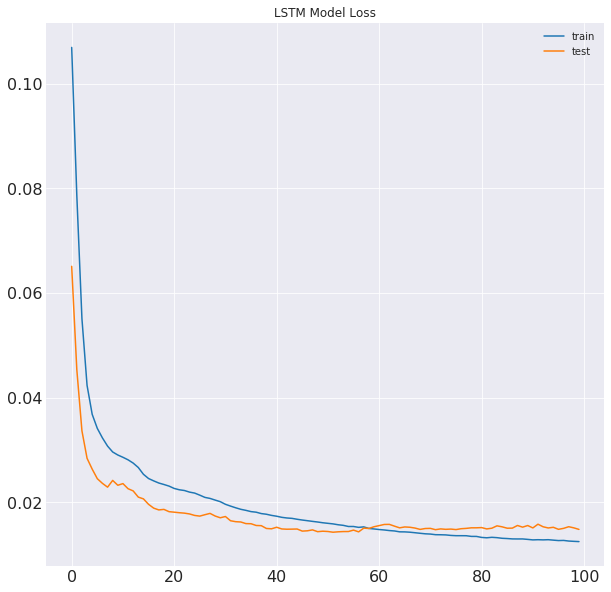

In [12]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [15]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 299:311], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 299:311], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9693522040506177
MAE:  832.7807
RMSE: 1152.4584048893043
mean absolute error percentage:  7.682083547115326


Time sequence 12hours(from 11 hours get 1 hours)

In [16]:
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 11

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [17]:
# delete significantly wrong data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3:, -1])
n_p = n_p + 365*24*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [18]:
# split into train and test sets# split i # split  
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 143) 26280 (26280,)
(26280, 11, 13) (26280,) (6540, 11, 13) (6540,)


In [19]:
# design network
model = Sequential()
model.add(LSTM(12, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6540 samples
Epoch 1/100
 - 2s - loss: 0.1233 - val_loss: 0.0751
Epoch 2/100
 - 2s - loss: 0.0910 - val_loss: 0.0632
Epoch 3/100
 - 2s - loss: 0.0712 - val_loss: 0.0522
Epoch 4/100
 - 2s - loss: 0.0517 - val_loss: 0.0434
Epoch 5/100
 - 2s - loss: 0.0422 - val_loss: 0.0322
Epoch 6/100
 - 2s - loss: 0.0379 - val_loss: 0.0291
Epoch 7/100
 - 2s - loss: 0.0356 - val_loss: 0.0275
Epoch 8/100
 - 2s - loss: 0.0340 - val_loss: 0.0261
Epoch 9/100
 - 2s - loss: 0.0330 - val_loss: 0.0251
Epoch 10/100
 - 2s - loss: 0.0319 - val_loss: 0.0243
Epoch 11/100
 - 2s - loss: 0.0310 - val_loss: 0.0241
Epoch 12/100
 - 2s - loss: 0.0302 - val_loss: 0.0238
Epoch 13/100
 - 2s - loss: 0.0296 - val_loss: 0.0233
Epoch 14/100
 - 2s - loss: 0.0290 - val_loss: 0.0232
Epoch 15/100
 - 2s - loss: 0.0286 - val_loss: 0.0234
Epoch 16/100
 - 2s - loss: 0.0283 - val_loss: 0.0231
Epoch 17/100
 - 2s - loss: 0.0281 - val_loss: 0.0228
Epoch 18/100
 - 2s - loss: 0.0278 - val_loss: 0.0232
Epoch 

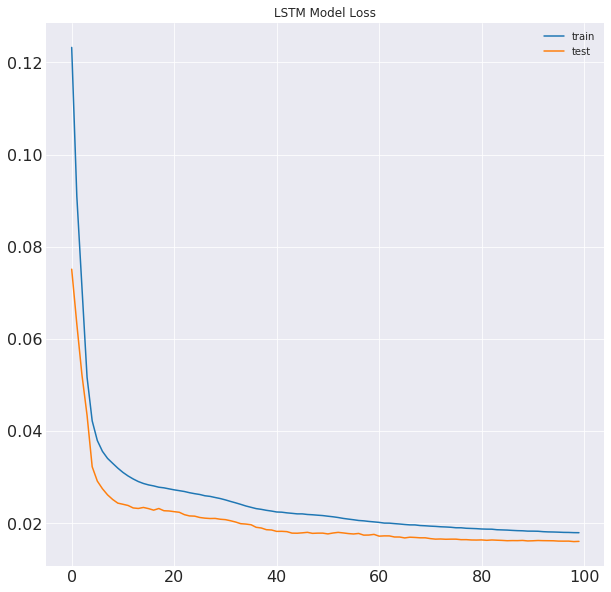

In [20]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [21]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 143:155], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 143:155], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)

R2:   0.9649349937593417
MAE:  899.7727
RMSE: 1232.0357644971189
mean absolute error percentage:  9.492924809455872


Time sequence 48hours(from 47 hours get 1 hours)

In [22]:
features_and_target = pd.concat([data, num_pickups], axis = 1)
values = features_and_target.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range = (0, 1))
scaled = scaler.fit_transform(values)

n_hours = 47

reframed = series_to_supervised(scaled, n_hours, 1)

n_features = features_and_target.shape[1]


In [23]:
# delete significantly wrong data
total_values = reframed.values
n_p = np.argmin(total_values[365*24*3:, -1])
n_p = n_p + 365*24*3

a = total_values[: n_p, :]
b = total_values[n_p + n_hours + 1 : , :]
values = np.concatenate((a, b), axis=0)

In [24]:
# split into train and test sets# split i # split  
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X, test_y = test[:, :n_obs], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 611) 26280 (26280,)
(26280, 47, 13) (26280,) (6468, 47, 13) (6468,)


In [ ]:
# design network
model = Sequential()
model.add(LSTM(48, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=100,
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 6468 samples
Epoch 1/100
 - 13s - loss: 0.1190 - val_loss: 0.0648
Epoch 2/100
 - 14s - loss: 0.0636 - val_loss: 0.0431
Epoch 3/100
 - 14s - loss: 0.0449 - val_loss: 0.0329
Epoch 4/100
 - 14s - loss: 0.0387 - val_loss: 0.0307
Epoch 5/100
 - 14s - loss: 0.0351 - val_loss: 0.0248
Epoch 6/100
 - 14s - loss: 0.0305 - val_loss: 0.0266
Epoch 7/100
 - 14s - loss: 0.0277 - val_loss: 0.0227
Epoch 8/100
 - 14s - loss: 0.0261 - val_loss: 0.0248
Epoch 9/100
 - 14s - loss: 0.0246 - val_loss: 0.0247
Epoch 10/100
 - 14s - loss: 0.0235 - val_loss: 0.0196
Epoch 11/100
 - 14s - loss: 0.0228 - val_loss: 0.0205
Epoch 12/100
 - 14s - loss: 0.0224 - val_loss: 0.0205
Epoch 13/100
 - 14s - loss: 0.0220 - val_loss: 0.0205
Epoch 14/100
 - 14s - loss: 0.0214 - val_loss: 0.0207
Epoch 15/100
 - 14s - loss: 0.0208 - val_loss: 0.0211
Epoch 16/100
 - 14s - loss: 0.0201 - val_loss: 0.0211
Epoch 17/100
 - 14s - loss: 0.0195 - val_loss: 0.0201
Epoch 18/100
 - 14s - loss: 0.0192 - val_l

In [ ]:
history_loss = pd.DataFrame()
history_loss['train'] = history.history['loss']
history_loss['test'] = history.history['val_loss']
history_loss.plot(figsize=(10,10), fontsize=16,
                title='LSTM Model Loss');

In [ ]:
# make a prediction 
yhat = model.predict(test_X)
# reshape back to 2d
test_X = test_X.reshape((test_X.shape[0], -1))

# invert scaling for forecast# invert 
inv_yhat = np.concatenate((test[:, 611:623], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test[:, 611:623], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
inv_yhat_gte_zero = inv_yhat.copy()
inv_yhat_gte_zero[inv_yhat_gte_zero < 0] = 0

# calculate r2
print("R2:  ", r2_score(inv_y, inv_yhat))

# calculate mean absolute error
print("MAE: ", mean_absolute_error(inv_y, inv_yhat))

# calculate rmse
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print("RMSE:", rmse)

# calculate mean absolute error percentage
maep = np.mean(np.abs((inv_y - inv_yhat)/inv_y))*100
print("mean absolute error percentage: ", maep)